In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from glob import glob
%matplotlib inline

In [208]:
any_stack_heights = np.loadtxt('any-stack-v2-steps-37k/transitions/stack-height.log.txt')
any_stack_actions = np.loadtxt('any-stack-v2-steps-37k/transitions/executed-action.log.txt')
any_stack_trials = np.loadtxt('any-stack-v2-steps-37k/transitions/trial.log.txt')
transfer_heights = np.loadtxt('first-grasp-to-stack-transfer-run-3k-actions-stack/transitions/stack-height.log.txt')
transfer_actions = np.loadtxt('first-grasp-to-stack-transfer-run-3k-actions-stack/transitions/executed-action.log.txt')
transfer_trials = np.loadtxt('first-grasp-to-stack-transfer-run-3k-actions-stack/transitions/trial.log.txt')
grasp_actions = np.loadtxt('train-grasp-place-split-efficientnet-21k-acc/transitions/executed-action.log.txt')
grasp_trials = np.loadtxt('train-grasp-place-split-efficientnet-21k-acc/transitions/trial.log.txt')
grasp_rewards = np.loadtxt('train-grasp-place-split-efficientnet-21k-acc/transitions/reward-value.log.txt')
# row_lengths = np.loadtxt('check_row/transitions/stack-height.log.txt')
# row_actions = np.loadtxt('check_row/transitions/executed-action.log.txt')
window=1000

In [55]:
trials = any_stack_trials
heights = any_stack_heights
print((trials[1:] > trials[:-1]).sum())
print((heights == 4).sum())
print(np.logical_and(trials[1:] > trials[:-1], heights == 4).sum())

4619
2260
2260


[1. 0. 1. ... 1. 1. 1.]


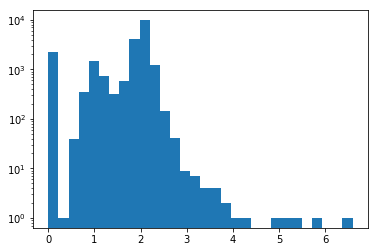

In [35]:
print(grasp_actions[:, 0])
plt.hist(grasp_label_value, bins=30)
plt.yscale('log')

In [251]:
def get_grasp_success_rate(actions, rewards=None, window=200, reward_threshold=0.5):
    """Evaluate moving window of grasp success rate
    actions: Nx4 array of actions giving [id, rotation, i, j]
    
    """
    grasps = actions[:, 0] == 1
    if rewards is None:
        places = actions[:, 0] == 2
    success_rate = np.zeros(actions.shape[0] - 1)
    lower = np.zeros_like(success_rate)
    upper = np.zeros_like(success_rate)
    for i in range(success_rate.shape[0]):
        start = max(i - window, 0)
        if rewards is None:
            successes = places[start+1: i+2][grasps[start:i+1]]
        else:
            successes = (rewards[start: i+1] > reward_threshold)[grasps[start:i+1]]
        success_rate[i] = successes.mean()
        var = np.sqrt(success_rate[i] * (1 - success_rate[i]) / successes.shape[0])
        lower[i] = success_rate[i] + 3*var
        upper[i] = success_rate[i] - 3*var
    lower = np.clip(lower, 0, 1)
    upper = np.clip(upper, 0, 1)
    return success_rate, lower, upper

def get_place_success_rate(stack_height, actions, include_push=False, window=200):
    """
    stack_heights: length N array of integer stack heights
    actions: Nx4 array of actions giving [id, rotation, i, j]
    
    where id=0 is a push, id=1 is grasp, and id=2 is place.
    
    """
    if include_push:
        success_possible = actions[:, 0] == 2
    else:
        success_possible = np.logical_or(actions[:, 0] == 0, actions[:, 0] == 2)
    
    stack_height_increased = np.zeros_like(stack_height, np.bool)
    stack_height_increased[0] = False
    stack_height_increased[1:] = stack_height[1:] > stack_height[:-1]
    
    success_rate = np.zeros_like(stack_height)
    lower = np.zeros_like(success_rate)
    upper = np.zeros_like(success_rate)
    for i in range(stack_height.shape[0]):
        start = max(i - window, 0)
        successes = stack_height_increased[start:i+1][success_possible[start:i+1]]
        success_rate[i] = successes.mean()
        success_rate[np.isnan(success_rate)] = 0
        var = np.sqrt(success_rate[i] * (1 - success_rate[i]) / successes.shape[0])
        lower[i] = success_rate[i] + 3*var
        upper[i] = success_rate[i] - 3*var
    lower = np.clip(lower, 0, 1)
    upper = np.clip(upper, 0, 1)
    return success_rate, lower, upper

def get_action_efficiency(stack_height, window=200, ideal_actions_per_trial=6, max_height=4):
    """Calculate the running action efficiency from successful trials.

    trials: array giving the number of trials up to iteration i (TODO: unused?)
    min_actions: ideal number of actions per trial
    
    Formula: successful_trial_count * ideal_actions_per_trial / window_size
    """

    success = stack_height == max_height
    efficiency = np.zeros_like(stack_height, np.float64)
    lower = np.zeros_like(efficiency)
    upper = np.zeros_like(efficiency)
    for i in range(1, efficiency.shape[0]):
        start = max(i - window, 1)
        window_size = min(i, window)
        num_trials = success[start:i+1].sum()
        efficiency[i] = num_trials * ideal_actions_per_trial / window_size
        var = efficiency[i] / np.sqrt(window_size)
        lower[i] = efficiency[i] + 3*var
        upper[i] = efficiency[i] - 3*var
    lower = np.clip(lower, 0, 1)
    upper = np.clip(upper, 0, 1)
    return efficiency, lower, upper

def get_grasp_action_efficiency(actions, rewards, reward_threshold=0.5, window=200, ideal_actions_per_trial=3):
    """Get grasp efficiency from when the trial count increases.
    
    """
    grasps = actions[:, 0] == 1
    efficiency = np.zeros_like(trials, np.float64)
    lower = np.zeros_like(efficiency)
    upper = np.zeros_like(efficiency)
    for i in range(efficiency.shape[0]):
        start = max(i - window, 0)
        window_size = min(i+1, window)
        successful = rewards[start: i+1] > reward_threshold
        successful_grasps = successful[grasps[start:start+successful.shape[0]]].sum()
        efficiency[i] = successful_grasps / window_size
        var = efficiency[i] / np.sqrt(window_size)
        lower[i] = efficiency[i] + 3*var
        upper[i] = efficiency[i] - 3*var
    lower = np.clip(lower, 0, 1)
    upper = np.clip(upper, 0, 1)
    return efficiency, lower, upper

In [199]:
window = 1000
heights = any_stack_heights
actions = any_stack_actions
trials = any_stack_trials
grasp_rate, grasp_lower, grasp_upper = get_grasp_success_rate(actions, window=window)
place_rate, place_lower, place_upper = get_place_success_rate(heights, actions, window=window)
eff, eff_lower, eff_upper = get_action_efficiency(heights, window=window)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


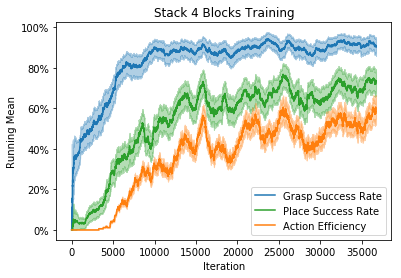

In [200]:
colors = ['tab:blue', 'tab:green', 'tab:orange']
alpha = 0.35
mult = 100

plt.plot(mult*grasp_rate, color=colors[0], label='Grasp Success Rate')
plt.plot(mult*place_rate, color=colors[1], label='Place Success Rate')
plt.plot(mult*eff, color=colors[2], label='Action Efficiency')

plt.fill_between(np.arange(1, grasp_rate.shape[0]+1), 
                 mult*grasp_lower, mult*grasp_upper,
                 color=colors[0], alpha=alpha)
plt.fill_between(np.arange(1, place_rate.shape[0]+1), 
                 mult*place_lower, mult*place_upper,
                 color=colors[1], alpha=alpha)
plt.fill_between(np.arange(1, eff.shape[0]+1), 
                 mult*eff_lower, mult*eff_upper,
                 color=colors[2], alpha=alpha)

ax = plt.gca()
plt.xlabel('Iteration')
plt.ylabel('Running Mean')
plt.title('Stack 4 Blocks Training')
plt.legend()
ax.yaxis.set_major_formatter(PercentFormatter())
plt.savefig('grasp_place_stack_efficiency.pdf')

In [258]:
window = 200
actions = grasp_actions
rewards = grasp_rewards
trials = grasp_trials
grasp_rate, grasp_lower, grasp_upper = get_grasp_success_rate(actions, rewards=rewards, window=window)
eff, eff_lower, eff_upper = get_grasp_action_efficiency(actions, rewards, window=window)

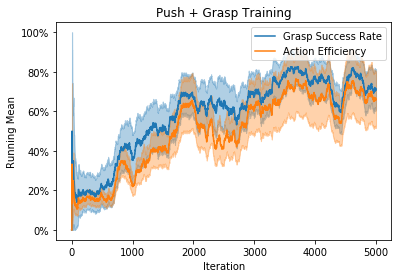

In [259]:
colors = ['tab:blue', 'tab:green', 'tab:orange']
alpha = 0.35
mult = 100
iters = 5000
grasp_rate = grasp_rate[:iters]
grasp_lower = grasp_lower[:iters]
grasp_upper = grasp_upper[:iters]
eff = eff[:iters]
eff_lower = eff_lower[:iters]
eff_upper = eff_upper[:iters]

plt.plot(mult*grasp_rate, color=colors[0], label='Grasp Success Rate')
plt.plot(mult*eff, color=colors[2], label='Action Efficiency')

plt.fill_between(np.arange(1, grasp_rate.shape[0]+1), 
                 mult*grasp_lower, mult*grasp_upper,
                 color=colors[0], alpha=alpha)
plt.fill_between(np.arange(1, eff.shape[0]+1), 
                 mult*eff_lower, mult*eff_upper,
                 color=colors[2], alpha=alpha)

ax = plt.gca()
plt.xlabel('Iteration')
plt.ylabel('Running Mean')
plt.title('Push + Grasp Training')
plt.legend()
ax.yaxis.set_major_formatter(PercentFormatter())
plt.savefig('grasp_efficiency.pdf')

In [195]:
window = 1000
heights = transfer_heights
actions = transfer_actions
trials = transfer_trials
grasp_rate, grasp_lower, grasp_upper = get_grasp_success_rate(actions, window=window)
place_rate, place_lower, place_upper = get_place_success_rate(heights, actions, window=window)
eff, eff_lower, eff_upper = get_action_efficiency(heights, window=window)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


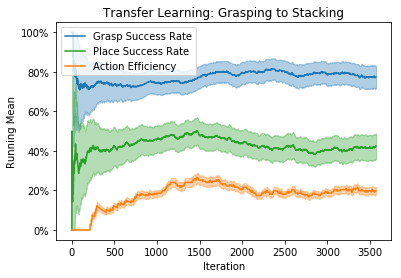

In [198]:
colors = ['tab:blue', 'tab:green', 'tab:orange']
alpha = 0.35
mult = 100

plt.plot(mult*grasp_rate, color=colors[0], label='Grasp Success Rate')
plt.plot(mult*place_rate, color=colors[1], label='Place Success Rate')
plt.plot(mult*eff, color=colors[2], label='Action Efficiency')

plt.fill_between(np.arange(1, grasp_rate.shape[0]+1), 
                 mult*grasp_lower, mult*grasp_upper,
                 color=colors[0], alpha=alpha)
plt.fill_between(np.arange(1, place_rate.shape[0]+1), 
                 mult*place_lower, mult*place_upper,
                 color=colors[1], alpha=alpha)
plt.fill_between(np.arange(1, eff.shape[0]+1), 
                 mult*eff_lower, mult*eff_upper,
                 color=colors[2], alpha=alpha)

ax = plt.gca()
plt.xlabel('Iteration')
plt.ylabel('Running Mean')
plt.title('Transfer Learning: Grasping to Stacking')
plt.legend()
ax.yaxis.set_major_formatter(PercentFormatter())
plt.savefig('transfer_efficiency.pdf')